__Goal__: Test inversion

    After simulate a source galaxy and deflect it, it's time to test the inversion!


In [16]:
import autolens as al
import autolens.plot as aplt
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_6/Simulation_Data/"

### Input parameters
Defining same inputs used for Jampy simulation (you can find it in __input_parameters.txt__, inside Simulation Data folder). And the necessary inputs for Autolens. 

In [17]:
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 4.100                                                         #Source Redshift 
kappa_ = 1.1                                                         #kappa_s of DM profile
r_s    = 2.0                                                         #scale radius
q      = 0.85                                                          #Axis Ratio
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=0.02, phi=88) #external shear

### Reading Data

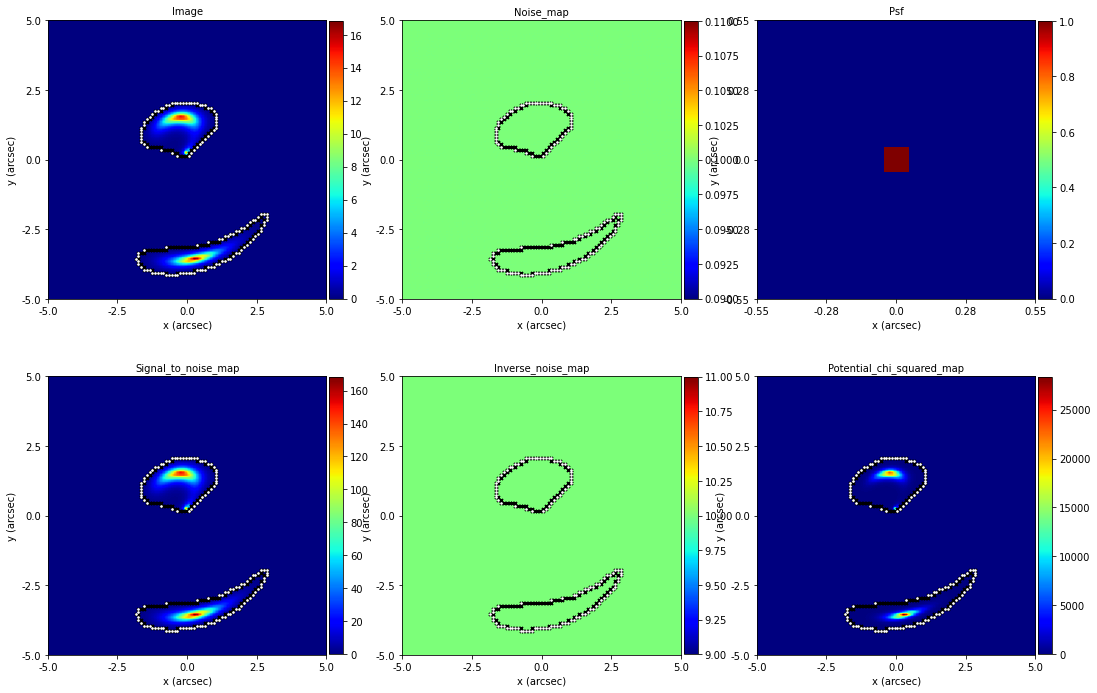

In [18]:
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/arcs_simulation.fits",
        noise_map_path=f"{data_folder}/noise_simulation.fits",
        psf_path=f"{data_folder}/psf_simulation.fits",
        pixel_scales=0.1,
    )

mask        = al.Mask.from_fits( file_path=f"{data_folder}/new_mask.fits", hdu=1, 
                                    pixel_scales=imaging.pixel_scales)#You should check Mask_Maker folder before continue

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)     #Masked image


aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask, include=aplt.Include(border=True),                         #Plot
)

In [19]:
masked_image.grid.shape

(834, 2)

## Starting model

In [20]:

#Initializing
ell_comps = al.convert.elliptical_comps_from(axis_ratio=q, phi=0.0) #Elliptical components in Pyautolens units
mass_profile = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_, elliptical_comps=ell_comps, scale_radius=r_s)

#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

In [21]:
#Now we set the tracer to the source galaxy

start = clock()

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=z_s)])
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_image.grid)[1]

print("Elapsed time", clock() - start)

Elapsed time 0.024985723008285277


We'll use the rectangular _Pixelization_ and _Mapper_ to perform the inversion.

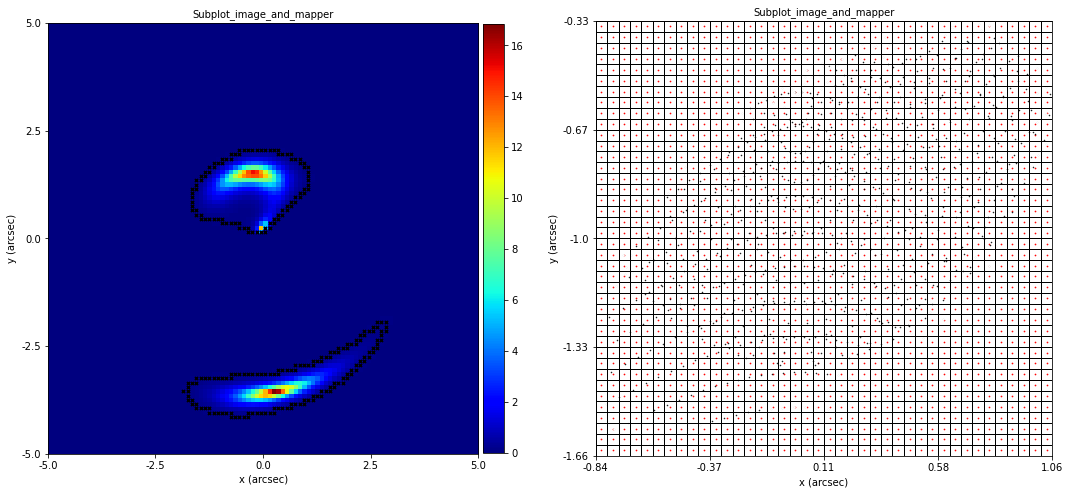

In [22]:
rectangular = al.pix.Rectangular(shape=(40, 40))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=True, inversion_grid=True),
)

And now, finally, we're going to use our _Mapper_ to invert the image using an _Inversion_.

In [23]:
start = clock()
inversion = al.Inversion(
    masked_dataset=masked_image,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=1.0),
)
print("Elapsed time", clock() - start)

Elapsed time 0.15332593199855182


Our _Inversion_ has a reconstructed image and _Pixeilzation_, whcih we can plot using an _Inversion_ plotter

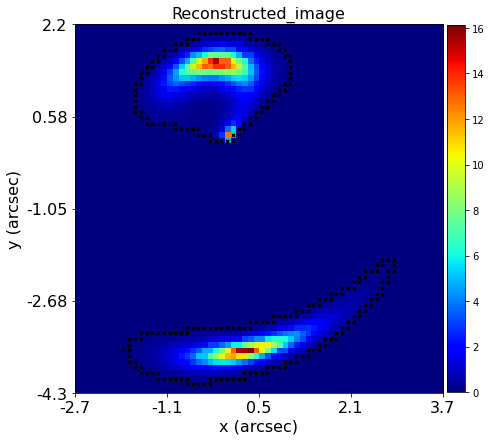

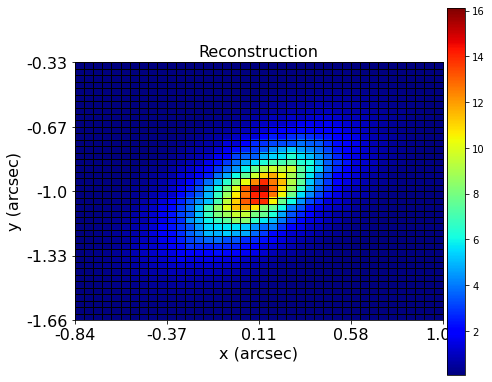

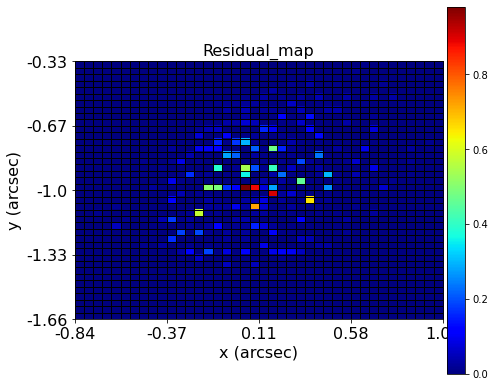

In [24]:
aplt.Inversion.reconstructed_image(inversion=inversion, include=aplt.Include(mask=True))

aplt.Inversion.reconstruction(
    inversion=inversion, include=aplt.Include(inversion_pixelization_grid=False, inversion_border=False)
)

aplt.Inversion.residual_map(inversion, include=aplt.Include(inversion_pixelization_grid=False,
                                                            inversion_border=False))

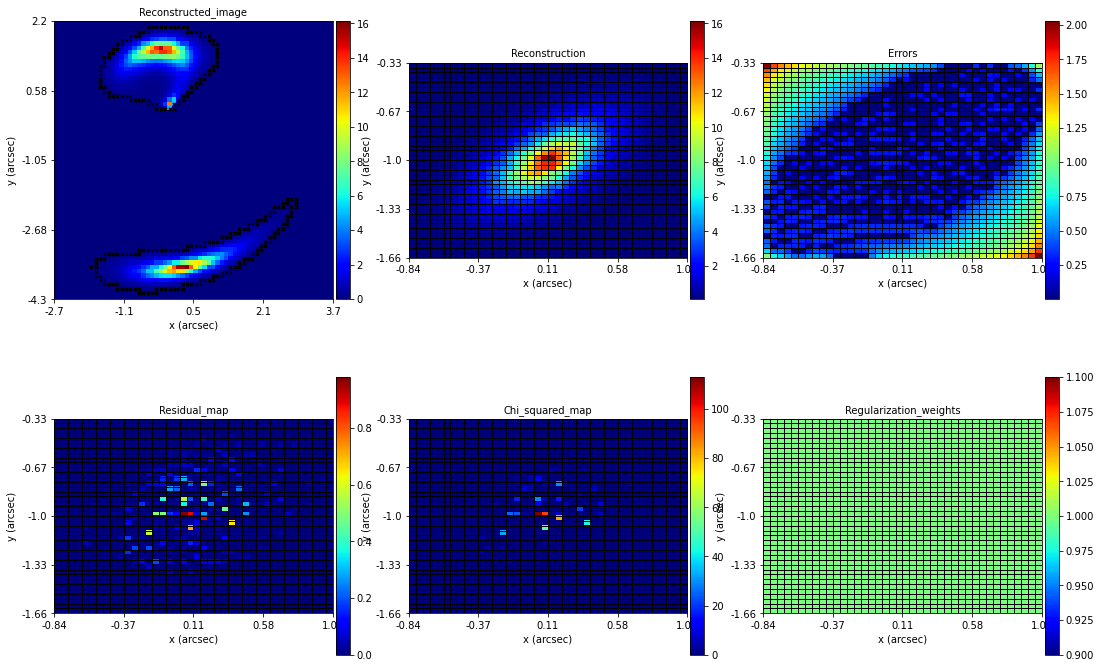

In [25]:
output=aplt.Output(path=data_folder,filename="Rectangular_Inversion", format="png")

plotter = aplt.SubPlotter(
    figure=aplt.Figure(figsize=(15, 15)),
    ticks=aplt.Ticks(ysize=5, xsize=8),
    labels=aplt.Labels(ysize=12, xsize=12, titlesize=12),output=output
)
#Save
aplt.Inversion.subplot_inversion(inversion,include=aplt.Include(inversion_border=False,
                                                                 inversion_pixelization_grid=False), sub_plotter=plotter)

#Plot
aplt.Inversion.subplot_inversion(inversion, include=aplt.Include(inversion_border=False,
                                                                 inversion_pixelization_grid=False))

## Inversion with Fit Tracer

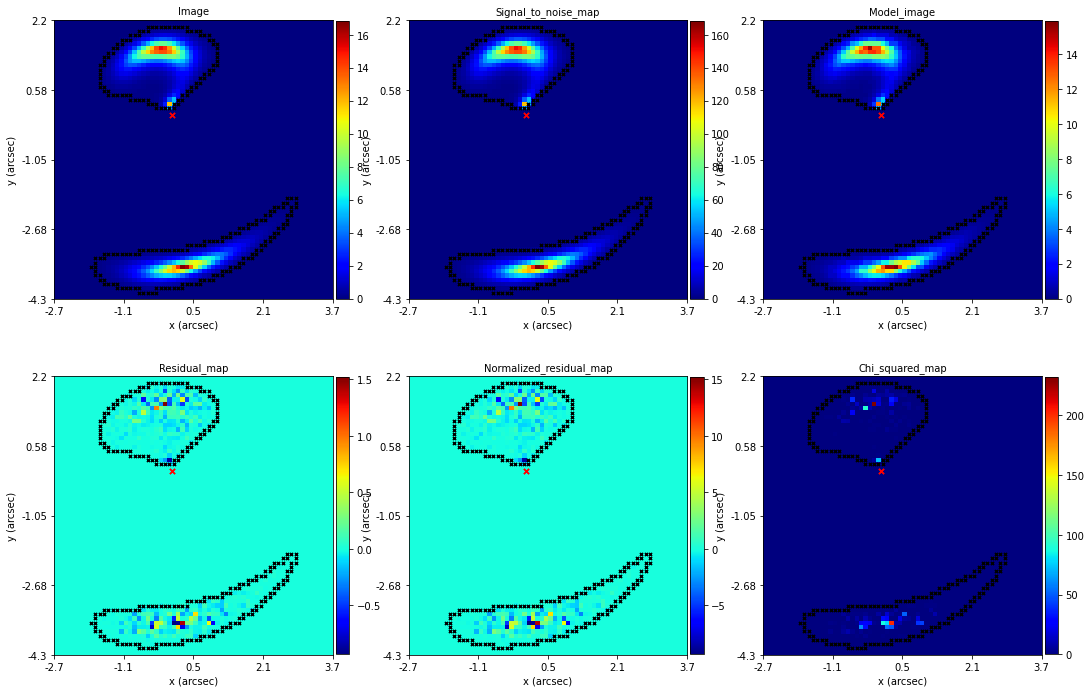

Log Likelihood with Regularization: -1310.737830779055


In [30]:
source_galaxy = al.Galaxy(
    redshift=z_s,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=2.0),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_image, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True,critical_curves=False,caustics=False))
print("Log Likelihood with Regularization:", fit.log_likelihood_with_regularization)